In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from keras import backend as K

In [13]:
# heat map counfusion matrix
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True)
    plt.show()

# metric function
def get_clf_eval(X_test,y_test, y_pred):
#     confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,average='micro')
    recall = recall_score(y_test, y_pred,average='micro')
    F1 = f1_score(y_test, y_pred,average='micro')
    
#     print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))


### Model Load and Data Preproceesing

In [14]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# calculate the sample mean and std
mu = X_train.mean()
# 0으로 나누는 것을 방지하기 위해서 매우 작은 값을 더해준다.
sig = X_train.std()+0.000000001

# normalize (z-score)
X_train = (X_train - mu) / sig
# print(X_train[0])

# train set과 동일한 평균과 표준편차로 test_set도 변경해줘야한다.
X_test = (X_test - mu) / sig # note! : use the same statistic with the training set!


# Change the shape of data from (W, W) to (W*W, )
# 여기서는 마지막에 1은 흑백사진이므로 채널을 맞춰주기 위해서 써준다.
X_train = X_train.reshape((-1, 28,28,1))
X_test = X_test.reshape((-1, 28,28,1))

# convert class vectors to binary class matrices (https://www.educative.io/edpresso/how-to-perform-one-hot-encoding-using-keras)
y_train_ONE = keras.utils.to_categorical(y_train,10)
y_test_ONE = keras.utils.to_categorical(y_test,10)

print(X_train.shape)
print(y_train_ONE.shape)
print(X_test.shape)
print(y_test_ONE.shape)


(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


### **Convolution layer**

In [10]:
## Model (https://keras.io/api/layers/)
## 2-layer CNN with MLP

model = keras.Sequential(
    [
      keras.layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1, 1),
        padding="valid",
        activation='relu',
        input_shape=(28,28,1)
      ),
      keras.layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1, 1),
        padding="valid",
        activation='relu',
      ),
     keras.layers.MaxPooling2D(
       pool_size=(2, 2), strides=None, padding="valid"
       ),
     keras.layers.Flatten(),
    #  hidden layer를 써도 됨
    #  layers.Dense(100,activation='relu'),
     keras.layers.Dense(10,activation='softmax')
    ],
    
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 10)                46090     
                                                                 
Total params: 55,658
Trainable params: 55,658
Non-trainable params: 0
____________________________________________________

In [15]:
## Train (https://keras.io/api/models/model_training_apis/)
batch_size = 64
epochs = 5

## compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) # keras.losses.MeanSq
## fit
hist = model.fit(x=X_train, y=y_train_ONE, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 83s 97ms/step - loss: 0.1687 - accuracy: 0.9505 - val_loss: 0.0605 - val_accuracy: 0.9823
Epoch 2/5
844/844 [==============================] - 85s 101ms/step - loss: 0.0550 - accuracy: 0.9831 - val_loss: 0.0463 - val_accuracy: 0.9875
Epoch 3/5
844/844 [==============================] - 83s 99ms/step - loss: 0.0393 - accuracy: 0.9876 - val_loss: 0.0453 - val_accuracy: 0.9873
Epoch 4/5
844/844 [==============================] - 83s 99ms/step - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.0485 - val_accuracy: 0.9875
Epoch 5/5
844/844 [==============================] - 83s 98ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0455 - val_accuracy: 0.9887


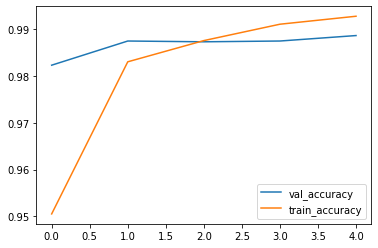

In [16]:
## plot loss and accuracy to check if the model is converged.
val_accuracy = hist.history['val_accuracy']
train_accuracy = hist.history['accuracy']

# 
from matplotlib import pyplot as plt
plt.figure()
plt.plot(np.arange(epochs),val_accuracy,label="val_accuracy")
plt.plot(np.arange(epochs),train_accuracy,label="train_accuracy")
plt.legend()
plt.show()


# 학습이 조금 부족하지만 일단 진행

313/313 [==============================] - 4s 14ms/step - loss: 0.0422 - accuracy: 0.9864
Test loss: 0.042161475867033005
Test accuracy: 0.9864000082015991


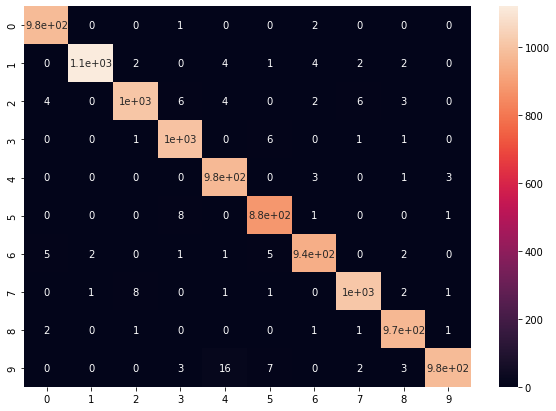

Accuracy: 0.9864


In [22]:
## evaluate on the test set.
score =model.evaluate(X_test, y_test_ONE, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



# reshape testing target to fit to scikit-learn metric form
# one hot encoding --> label
y_testPred = model.predict(X_test)
y_test_cnn = []
for y in y_testPred:
    y_test_cnn.append(y.argmax())
y_test_cnn = np.array(y_test_cnn)

# Confusion Marix
print_cmx(y_test, y_test_cnn)
print("Accuracy: {0}".format(accuracy_score(y_test, y_test_cnn)))

### **Feature extraction layer from CNN**

In [24]:
# keras model layer 확인
from keras import backend as K
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <keras.layers.convolutional.Conv2D object at 0x7f4e87903e10>
1 <keras.layers.convolutional.Conv2D object at 0x7f4e873c5990>
2 <keras.layers.pooling.MaxPooling2D object at 0x7f4e86b283d0>
3 <keras.layers.core.flatten.Flatten object at 0x7f4e86b288d0>
4 <keras.layers.core.dense.Dense object at 0x7f4e86b28950>


In [25]:
# Feature extraction layer
feature_extraion_layer= keras.Model(inputs=model.layers[0].input, outputs=model.layers[3].output, name="feature_extraion_layer")
feature_extraion_layer.summary()

Model: "feature_extraion_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
__________________________________________

In [ ]:
#Find the Features for n number of train images and we will get n x 4608
#This means we will get 4608 (Flatten layer) features for each images.

# CNN과 머신러닝 결합의 목적은 적은 data의 양으로도 좋은 성능을 보이는 머신러닝 알고리즘을 사용하려는 목적이므로
# 전체 data를 사용하지 않고 일부를 사용하여 학습 및 평가함
num_tran=3000
num_test=1000

features_train=np.zeros(shape=(num_tran,4608))
features_test=np.zeros(shape=(num_test,4608))

# train
i=0
for i in range(num_tran):
    FC_output_train = feature_extraion_layer.predict(X_train[i].reshape(-1,28,28))
    features_train[i]=FC_output_train
    print(f"train set {i}번째 완료")
    i+=1


# test
i=0
for i in range(num_test):
    FC_output_test = feature_extraion_layer.predict(X_test[i].reshape(-1,28,28))
    features_test[i]=FC_output_test
    print(f"test set {i}번째 완료")
    i+=1


print(features_train.shape , features_test.shape)

# save 
np.save('features_train', features_train)
np.save('features_test', features_test)

### **reshape target data**

In [31]:
y_train_clf=y_train[:3000]
y_test_clf=y_test[:1000]

### **SVM Classification with feature data**

In [32]:
# grid search
parameters = {'kernel':['rbf'], 
              'C':[1, 10, 100,],
              'gamma':[1e-3, 1e-4]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(features_train, y_train_clf)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']})

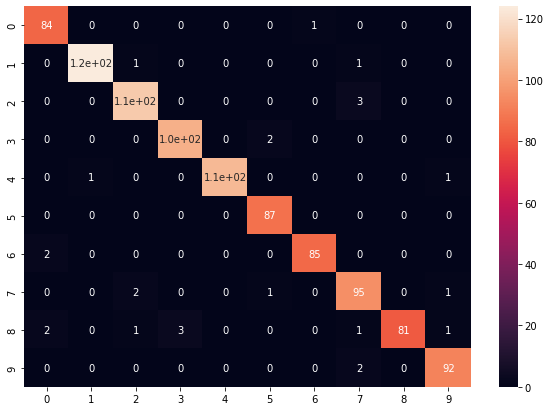

Accuracy: 0.974

정확도: 0.9740
정밀도: 0.9740
재현율: 0.9740
F1: 0.9740


In [35]:
svmclf = clf.best_estimator_
svmclf.fit(features_train, y_train_clf)

# evaluate
y_testSVM = svmclf.predict(features_test)

# Confusion Marix
print_cmx(y_test_clf, y_testSVM)
print("Accuracy: {0}".format(accuracy_score(y_test_clf, y_testSVM)))
get_clf_eval(features_test,y_test_clf, y_testSVM)

### **RandomForest Classification with feature data**

In [36]:
# grid search
parameters = {"max_depth": [3, None],
              "n_estimators": [10, 20, 50]}
rclf = RandomForestClassifier()
rgclf = GridSearchCV(rclf, param_grid=parameters)
rgclf.fit(features_train, y_train_clf)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, None], 'n_estimators': [10, 20, 50]})

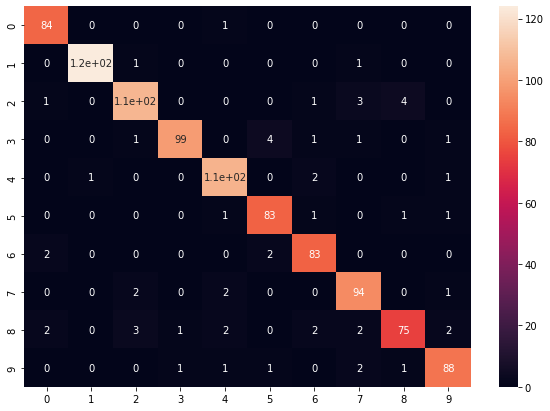

Accuracy: 0.943

정확도: 0.9430
정밀도: 0.9430
재현율: 0.9430
F1: 0.9430


In [37]:
# best parameter
rclf = rgclf.best_estimator_
rclf.fit(features_train, y_train_clf)

# evaluate 
y_testRF = rclf.predict(features_test)

# Confusion Marix
print_cmx(y_test_clf, y_testRF)
print("Accuracy: {0}".format(accuracy_score(y_test_clf, y_testRF)))
get_clf_eval(features_test,y_test_clf, y_testRF)

### **K-nearest neighbors Classification with feature data**

In [38]:
# grid search
parameters = {"n_neighbors": [1, 5, 10],
              "weights": ['distance'],
              "algorithm": ['auto']}
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters)
kgclf.fit(features_train, y_train_clf)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto'], 'n_neighbors': [1, 5, 10],
                         'weights': ['distance']})

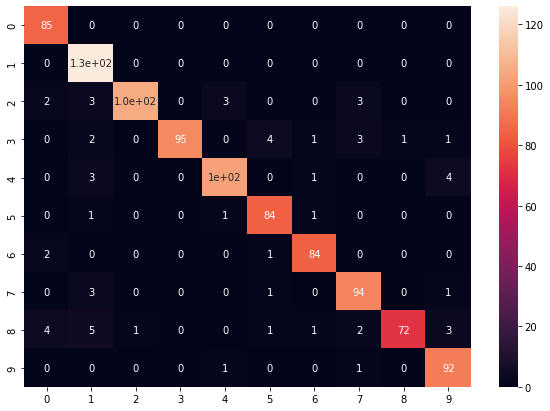

Accuracy: 0.939

정확도: 0.9390
정밀도: 0.9390
재현율: 0.9390
F1: 0.9390


In [39]:
# best parameter
kclf = kgclf.best_estimator_
kclf.fit(features_train, y_train_clf)

# evaluate
y_testKNN = kclf.predict(features_test)

# Confusion Marix
print_cmx(y_test_clf, y_testKNN)
print("Accuracy: {0}".format(accuracy_score(y_test_clf, y_testKNN)))
get_clf_eval(features_test,y_test_clf, y_testKNN)

결과적으로 정확도(acc)를 기준으로 CNN (Soft max) : 0.9864 / SVM : 0.974 / RandomForest : 0.943 / KNN : 0.939 의 성능을 보인다. 수치상으로 CNN이 좋아 보이나 위의 Feature 추출 과정에서 train 3000개 / test 1000개의 Feature를 추출하여 사용하였으므로 오히려 적은 data 에서의 분류 성능은 CNN+머신러닝 알고리즘을 같이 사용하였을 때 좋다고 판단할 수 있을 것이다

아래의 그래프에서 처럼 데이터의 양이 많다면 Deep learning의 성능이 좋지만 적은 데이터 상에서는 머신러닝의 정확도가 높으므로 각각의 상황에 맞게 선택하면 사용하는 것이 좋을 것 같다

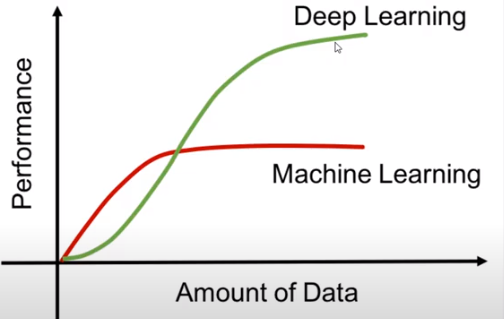